#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

In [2]:
test = pd.read_csv('test_data.csv')
train = pd.read_csv('train_data.csv')

#### Exploration of G3 Variable
What is G3?
>- G3 is the our target, what we are trying to predict
>- A students final grade 0-20

In [3]:
train.head()

,studentID,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Math,Portuguese
0,0,MS,M,17,U,GT3,T,3,3,services,services,home,mother,1,1,0,no,yes,no,yes,yes,yes,yes,no,4,1,4,5,5,3,8,7,10,9,no,yes
1,1,GP,M,15,U,GT3,T,4,4,services,teacher,course,father,1,2,0,no,yes,no,yes,yes,yes,yes,no,4,3,3,1,1,5,0,14,15,15,no,yes
2,2,GP,M,15,R,GT3,T,4,4,other,other,home,father,4,4,0,no,yes,no,yes,yes,yes,yes,yes,1,3,5,3,5,1,8,12,10,11,no,yes
3,3,GP,F,17,U,GT3,T,3,2,other,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,yes,4,3,2,2,3,2,0,12,13,15,no,yes
4,4,MS,F,18,U,LE3,T,1,1,at_home,services,course,father,2,3,0,no,no,no,no,yes,yes,yes,no,5,3,2,1,1,4,0,18,16,16,yes,no


In [70]:
train['G3'].describe()

count    835.000000
mean      11.320958
std        3.930448
min        0.000000
25%       10.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

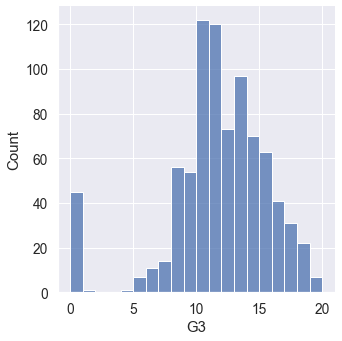

In [71]:
sns.displot(train['G3'], bins=20)

As you can see from this graph, it will be important to predict not just the final grade, but whether a student failed or not. 

In [72]:
#skewness and kurtosis
print("Skewness: %f" % train['G3'].skew())
print("Kurtosis: %f" % train['G3'].kurt())

Skewness: -0.981447
Kurtosis: 1.670935


In [73]:
num_cols = train._get_numeric_data().columns
categorical_cols = train.columns[~train.columns.isin(num_cols)]
num_cols.drop('G3')

Index(['studentID', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2'],
      dtype='object')

In [74]:
categorical_cols

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'Math', 'Portuguese'],
      dtype='object')

The following graphs show G3 mapped with each variable, this is a good way to see how the data is distributed, and if there are any patterns to help us predict G3.

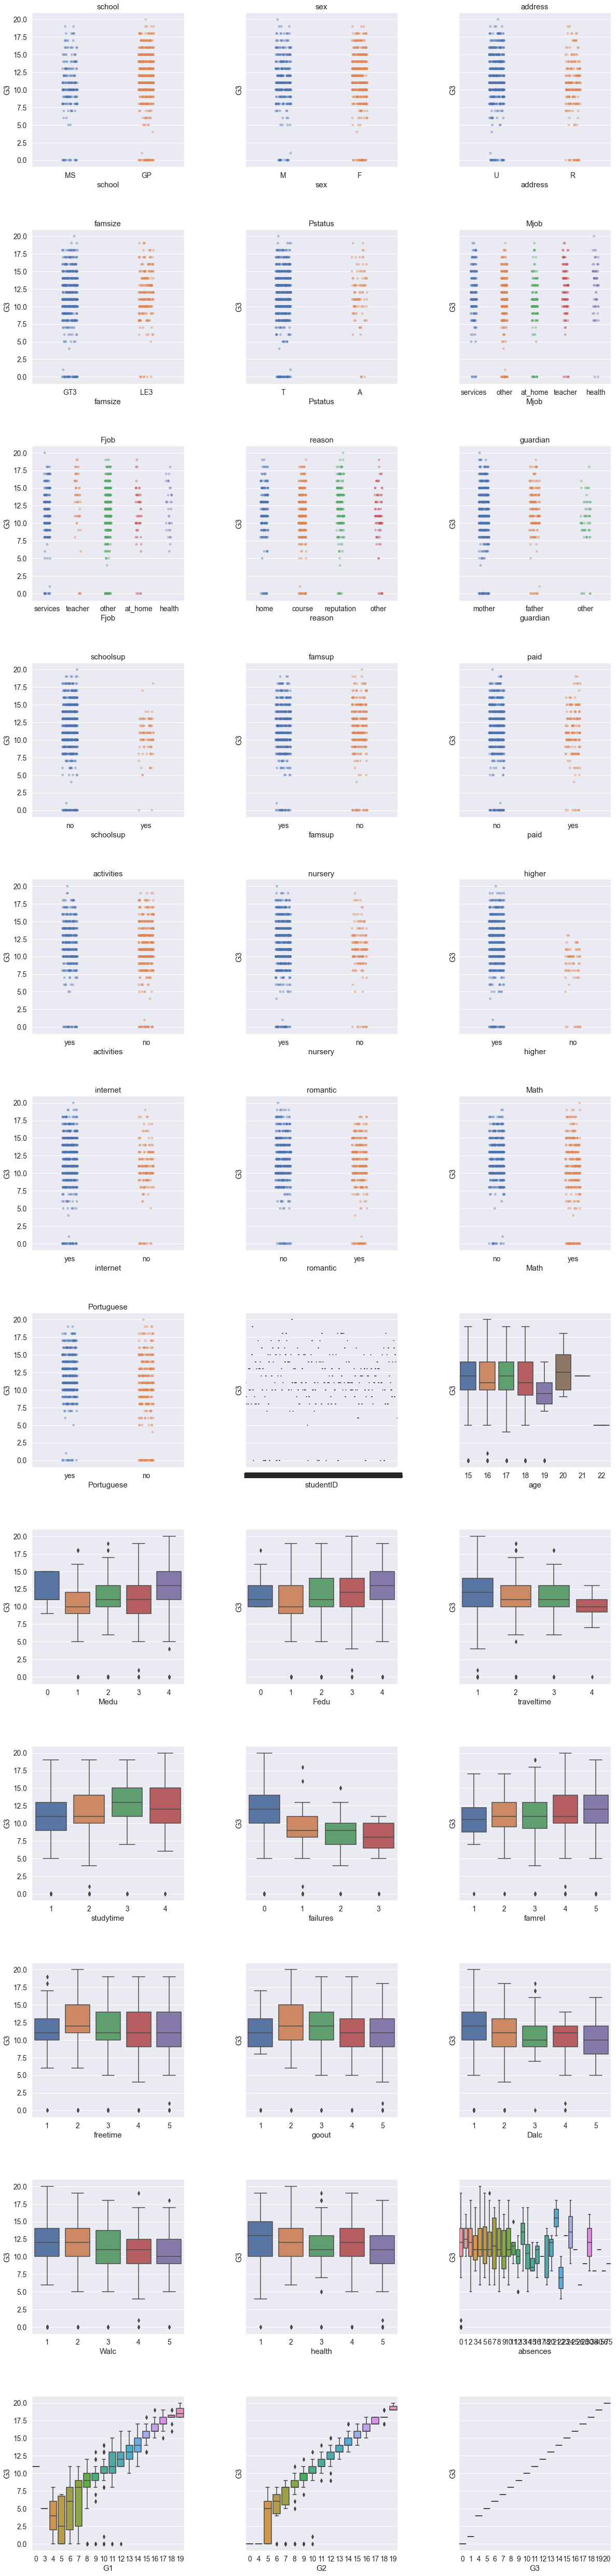

In [88]:
fig, axes = plt.subplots(12, 3, figsize=(20, 90), sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i=0
j=0
for col in categorical_cols:
    sns.stripplot(ax=axes[j,i], x=col, y='G3', data=train, jitter=True, edgecolor='none', alpha = 0.4)
    axes[j,i].set_title(col)
    if i == 2:
        j=j+1
        i=-1
    i+=1
    
for col in num_cols:
    sns.boxplot(ax=axes[j,i], x=col, y='G3', data=train)
    if i == 2:
        j=j+1
        i=-1
    i+=1

>- Let's keep these plots in mind when checking out the correlations below.
>- One important thing to note is that G1 and G2 are seemingly the only variables that have a strong correlation with G3. We will confirm/deny this in the next section. 

#### Encoding
- There are categorical variables that we can encode (turn to numeric varibales), we're going to do this in order to include them in our heatmap.
- Any variable that has no/yes values can be encoded to 0/1.

Norminal Encoding - Where order of data doesn't matter
- We will using One Hot Encoding (OHE)

Ordinal Encoding - Where order of data matters
- We will use Label Encoding

In [62]:
binary = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'Math', 'Portuguese', 'Pstatus', 'famsize', 'school']
nominal = ['Mjob', 'Fjob', 'reason', 'guardian']
ordinal = [] # There are no ordinal variables that aren't binary

In [63]:
# encode binary variables
# label_encoder object knows how to understand word labels.
label_encoder = LabelEncoder()

for i in binary:
    train[i] = label_encoder.fit_transform(train[i])

# encode nominal variables using one hot encoding
for j in nominal:
    train = pd.concat([train, pd.get_dummies(train[j], prefix=j)], axis=1)
    train.drop(j, axis=1, inplace=True)

#### Relationship with numeric variables

<AxesSubplot:>

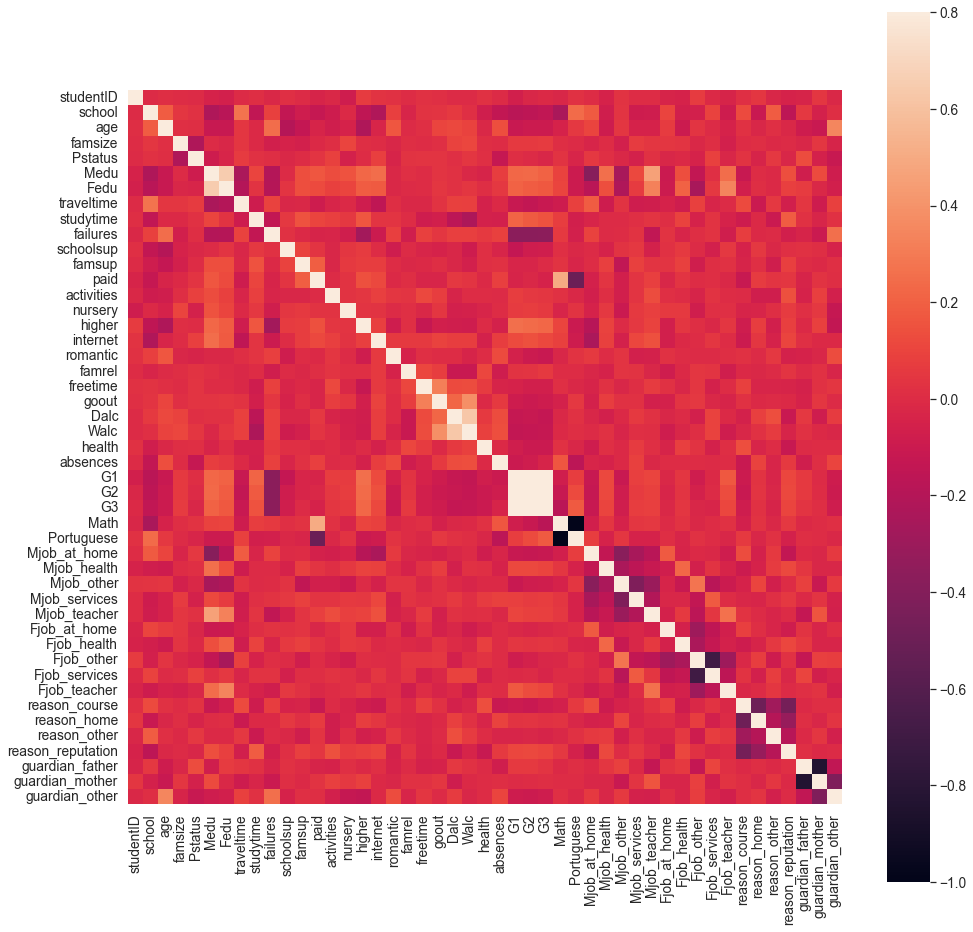

In [64]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, square=True)

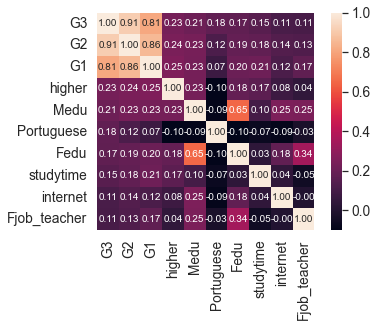

In [65]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'G3')['G3'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The heatmap is one of the best ways to get a quick overview of our data, seeing what correlation exists between the variables.

If we look at the 'G3' variable, there a few correlations to take note of,
- G1 and G2 : have very high correlation, we will plot them below to take a look
- failures : has a negative correlation - higher amount of failures, lower the grade
- studytime, higher(wants to take higher education),   : notable positive correlation, should help us in predicting the final grade
- the rest have around no correlation, most should still be used in modelling despite the lack of correlation, any help we can get will improve the model.

#### Twins
>- We can see that Math and Portuguese have an opposite correlation of eachother, only one of them will be valuble in the model.
>- They are essentially the same variable but opposite, include one will act as a binary value.
>- (A student is either a Portuguese or a Math student, not both)

In [90]:
train.drop(['Portuguese'], axis=1, inplace=True)

I hope this gave you an idea on where to start by understanding our variables to a deeper level.
Good luck everyone!